# Neural Networks Project
### Reimplementation of SemiTime

Course: Neural Networks - Master in Artificial Intelligence and Robotics 2022-2023

Student: Spagnoli Valerio 1887715

Paper: **Semi-supervised time series classification by temporal relation prediction** (https://haoyfan.github.io/papers/SemiTime_ICASSP2021.pdf)


### Descriprion of SemiTime

#### Main Idea

This project has been based on the paper "Semi-supervised time series classification by temporal relation prediction", which describes a novel approach for time series classification.
In this work the authors have proposed a method of semi-supervised time series classification architecture (termed as **SemiTime**) by gaining from the structure of unlabeled data in a self-supervised manner. 

The main idea of SemiTime is to use the labelled data of dataset for a classic supervised classification, and unlabelled data of dataset for a self-supervised temporal relation classification. \
The temporal relation classification is used to help the model in features extracting phase.

#### Model
There are two models:  
- backbone encoder $ f_{\theta} $ + classification head $ h_{\mu} $
- backbone encoder $ f_{\theta} $ + relation head $ h_{\phi} $

The backbone encoder is the same for both of models, and is a 4-layer 1D convolutional neural network with ReLU activation function and batch normalization.

The classification head is linear layer with output = number of classes of dataset.

The relation head is a two layer fully connected networks with 256 hidden neurons.

**Supervised classification of classes**:

The first model perform a supervised classification of classes: given the labelled dataset $ \mathcal{D}_L = \{(\textbf{t}_i, y_i)\}_{i=0}^M $, the backbone encoder $ f_{\theta} $ takes the time series as input to extract the feature embedding $ \mathcal{z}_i = f_{\theta}(\textbf{t}_i) $, and then the classification head $ h_{\mu} $ perfoms the multiclass classification. 

For this part has been used the Cross Entropy loss and Adam optimizer.

**Self-supervised classification of temporal relation**:

The second model perform a self-supervised classification of temporal relation between two segments. \
Given two segments, if the second is the future segmens of the first, they are in positive relation (labelled with 1), otherwise they are in negative relation (labelled with 0). \
So, given the unlabelled dataset  $ \mathcal{D}_U = \{(\textbf{t}_i)\}_{i=0}^N $, each time series has been split in two parts:
- the first part denotes the past segments,
- the second part denotes the future segmens.


For each segment in $ \mathcal{D}_U $ have been created 2 segments (both of them split in 2 parts):
- the first has been composed by the past and future parts of the same segmets, i.e. $ \textbf{s}_i $ and $ \textbf{s}_i^+ $ , and represents the positive relation (label = 1);
- the second has been composed by the same past segment of the first one, i.e. $ \textbf{s}_i $, but with a different future segment taken form another sample in $ \mathcal{D}_U $, i.e. $ \textbf{s}_j^- $. This segment represents the negative relation (label = 0);

The backbone encoder takes for each segment $ \textbf{s}_i $, $ \textbf{s}_i^+ $ and $ \textbf{s}_i^- $ to extract the features embedding $ \mathcal{z}_i = f_{\theta} (\textbf{s}_i) $, $ \mathcal{z}_i^+ = f_{\theta} (\textbf{s}_i^+) $ and $ \mathcal{z}_i^- = f_{\theta} (\textbf{s}_i)^- $, and then the relation head $ h_{\phi} $ perform temporal relation prediction between segments (binary classification problem):
- $ h_{\phi} = ([\mathcal{z}_i, \mathcal{z}_i^+ ])$ for positive relation;
- $ h_{\phi} = ([\mathcal{z}_i, \mathcal{z}_i^- ])$ for negative relation;
  
For this part has been used the Binary Cross Entropy loss and Adam optimizer.

Note: $[\cdot, \cdot ]$ is the concatenation operation.

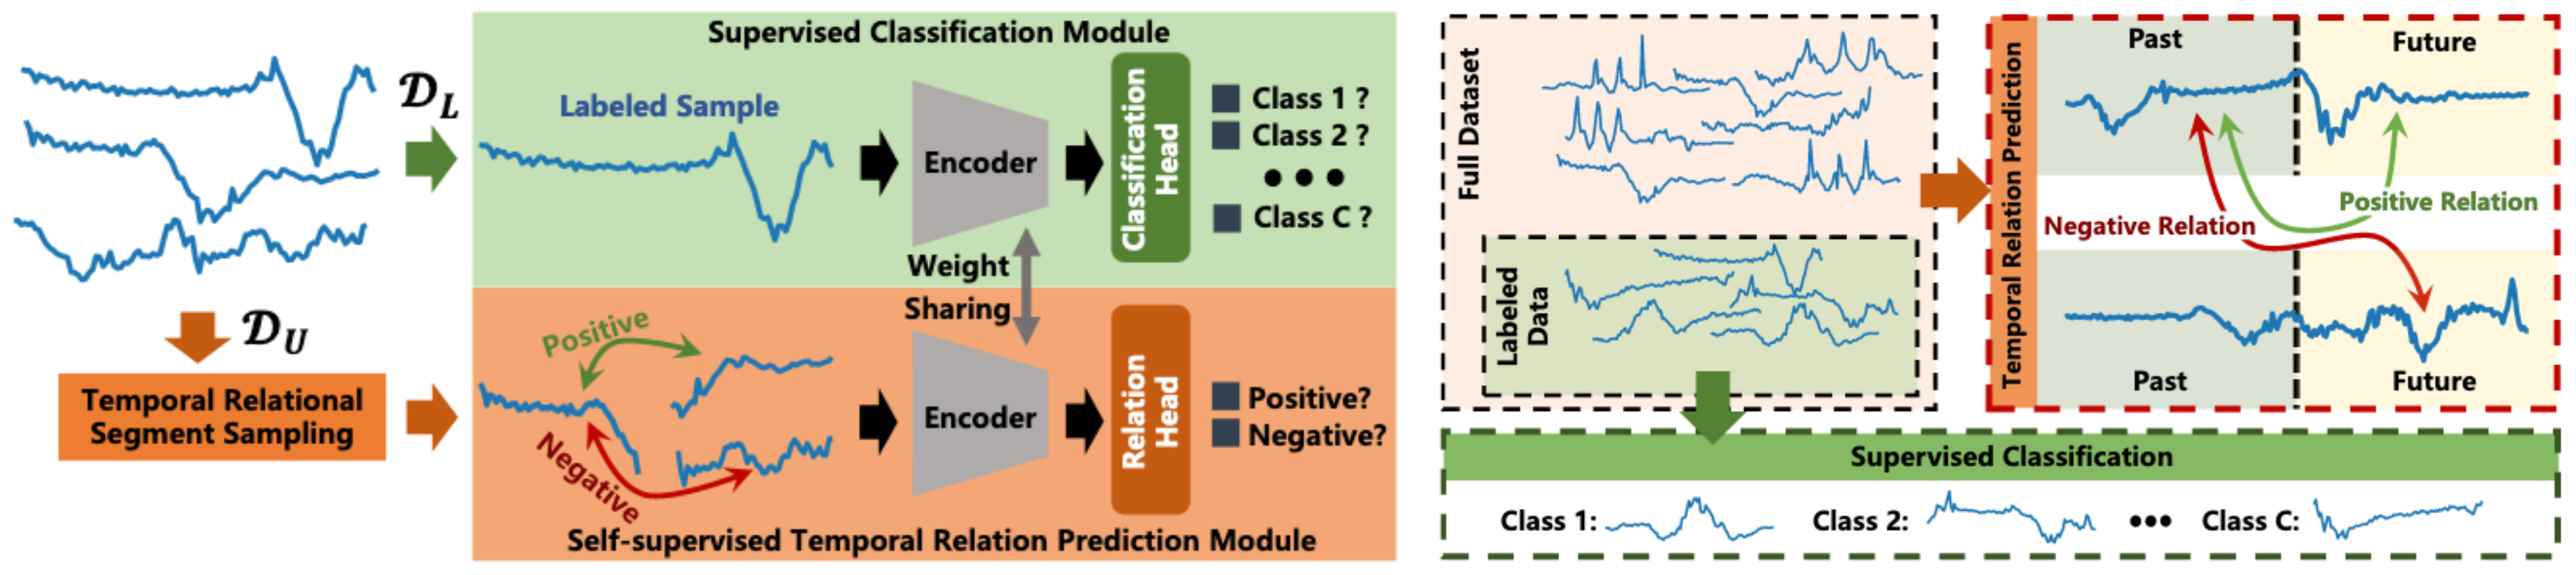

In [1]:
from IPython import display
display.Image("../images/semitime.jpg")

-----

### Datasets
Note: 
- the $\mathcal{D}_L$ dataset is contained in $\mathcal{D}_U $ and can be maximum equal to $\mathcal{D_U} $ (i.e. $ M \le N$).
- for supervised classificaiton part is used only $\mathcal{D}_L$
- for self-supervised classificaiton part is used the entire dataset $ \mathcal{D}_U $, also the labelled data (without taking the label).

For this project are used the following dataset:
- CricketX, UWaveGestureLibraryAll, InsectWingbeatSound: http://www.timeseriesclassification.com/dataset.php 
- XJTU bearing dataset: https://biaowang.tech/xjtu-sy-bearing-datasets/ 
- MFPT fault dataset: https://www.mfpt.org/fault-data-sets/ 
- Epilectic Seizure Recognitions: https://archive-beta.ics.uci.edu/dataset/388/epileptic+seizure+recognition 
  
and is used always the entire dataset both for supervised and semi-supervised tasks.

-----

### Training

In [2]:
from main import get_dataset, supervised, semi_supervised, test_model
from settings import globalSettings

#### Global settings

With module globalSetting you can create a 'setter' with all the necessary settings.
- dataset: name of dataset
- num_folds: number of fold of K-Fold Cross Validations
- batch_size: number of samples in one batch
- num_features: number of features returned from backbone
- learning_rate: learning rate of Adam optimizer
- patience: number of epochs without stopping where loss > minimum recordered loss on current fold
- device: can be 'cpu', 'cuda', 'mps', depending on the available hardware.

In [3]:
setter = globalSettings.GlobalSettings(dataset='CricketX', 
                                        num_folds=8, 
                                        num_epochs=1000, 
                                        batch_size=128, 
                                        num_features=64, 
                                        learning_rate=0.01, 
                                        patience=200,
                                        device='mps') # choose here the device ('cpu', 'cuda', 'mps')


dataset_name = setter.__get_settings__(variable='dataset')
num_features = setter.__get_settings__(variable='num_features')
learning_rate = setter.__get_settings__(variable='learning_rate')
split_ratio = setter.__get_settings__(variable='split_ratio')
device = setter.__get_settings__(variable='device')

#### Load datasets

This function returns the labelled dataset $\mathcal{D}_L$, the unlabelled dataset $\mathcal{D}_U$ (already splitted in past and future segments), the test dataset and the number of classes. 

In [4]:
labelledDataset, unlabelledDataset, testDataset, num_classes = get_dataset(dataset_name=dataset_name, split_ratio=split_ratio)

#### Training

**Note: the parameter 'save' is set to False. If you set this parameter to 'True' and run the cell, all previous checkpoints of the loaded dataset are automatically lost.**

##### Supervised training

In [ ]:
backbone_s, clf_head_s = supervised(labelledDataset=labelledDataset, num_classes=num_classes, num_features=num_features, 
                                    learning_rate=learning_rate, device=device, setter=setter, save=False)

backbone_s, clf_head_s = backbone_s.to('cpu'), clf_head_s.to('cpu')

##### Semi-Supervised training

In [ ]:
backbone_ss, clf_head_ss = semi_supervised(labelledDataset=labelledDataset, unlabelledDataset=unlabelledDataset, num_classes=num_classes, num_features=num_features, 
                                           learning_rate=learning_rate, device=device, setter=setter, save=False)

backbone_ss, clf_head_ss = backbone_ss.to('cpu'), clf_head_ss.to('cpu')

----

### Test

If a model (backbone + clf_head) is passed to the function, it will test the model passed as argument, otherwise it performs the test on the model saved in './checkpoint/{task}/{dataset_name}'.

Note: the parameter 'task' can be 'supervised' or 'semi-supervised'.

In [16]:
test_model(task='supervised', dataset_name=dataset_name, dataset=testDataset, num_classes=num_classes, num_features=num_features, 
           backbone=backbone_s, clf_head=clf_head_s)

[TEST]:
   - approach: supervised
   - dataset:  CricketX
Loss: 2.424
Accuracy: 36.667%



In [17]:
test_model(task='semi-supervised', dataset_name=dataset_name, dataset=testDataset, num_classes=num_classes, num_features=num_features, 
           backbone=backbone_ss, clf_head=clf_head_ss)

[TEST]:
   - approach: semi-supervised
   - dataset:  CricketX
Loss: 1.990
Accuracy: 37.692%



----

### Results

#### Results published in the paper

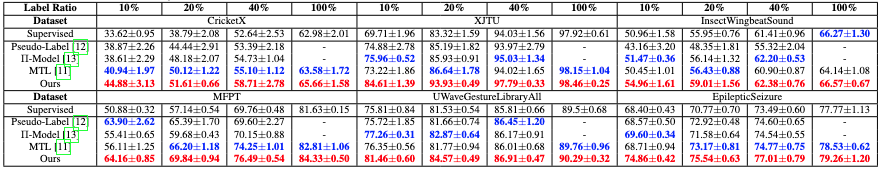

In [2]:
display.Image("../images/results_paper.png")

#### Results of this project

In [5]:
_,_, CricketX_test, num_classes_CricketX = get_dataset(dataset_name='CricketX', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='CricketX', dataset=CricketX_test, num_classes=num_classes_CricketX, num_features=num_features)
test_model(task='semi-supervised', dataset_name='CricketX', dataset=CricketX_test, num_classes=num_classes_CricketX, num_features=num_features)

[TEST]:
 - approach: supervised
 - dataset:  CricketX
Loss: 2.166
Accuracy: 40.256%

[TEST]:
 - approach: semi-supervised
 - dataset:  CricketX
Loss: 1.861
Accuracy: 44.103%



In [7]:
_,_, UWaveGestureLibraryAll_test, num_classes_UWaveGestureLibraryAll = get_dataset(dataset_name='UWaveGestureLibraryAll', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='UWaveGestureLibraryAll', dataset=UWaveGestureLibraryAll_test, num_classes=num_classes_UWaveGestureLibraryAll, num_features=num_features)
test_model(task='semi-supervised', dataset_name='UWaveGestureLibraryAll', dataset=UWaveGestureLibraryAll_test, num_classes=num_classes_UWaveGestureLibraryAll, num_features=num_features)

[TEST]:
 - approach: supervised
 - dataset:  UWaveGestureLibraryAll
Loss: 1.288
Accuracy: 57.091%

[TEST]:
 - approach: semi-supervised
 - dataset:  UWaveGestureLibraryAll
Loss: 1.257
Accuracy: 54.104%



In [8]:
_,_, InsectWingbeatSound_test, num_classes_InsectWingbeatSound = get_dataset(dataset_name='InsectWingbeatSound', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='InsectWingbeatSound', dataset=InsectWingbeatSound_test, num_classes=num_classes_InsectWingbeatSound, num_features=num_features)
test_model(task='semi-supervised', dataset_name='InsectWingbeatSound', dataset=InsectWingbeatSound_test, num_classes=num_classes_InsectWingbeatSound, num_features=num_features)

[TEST]:
 - approach: supervised
 - dataset:  InsectWingbeatSound
Loss: 2.250
Accuracy: 32.172%

[TEST]:
 - approach: semi-supervised
 - dataset:  InsectWingbeatSound
Loss: 1.878
Accuracy: 33.990%



In [9]:
_,_, MFPT_test, num_classes_MFPT = get_dataset(dataset_name='MFPT', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='MFPT', dataset=MFPT_test, num_classes=num_classes_MFPT, num_features=num_features)
test_model(task='semi-supervised', dataset_name='MFPT', dataset=MFPT_test, num_classes=num_classes_MFPT, num_features=num_features)

[TEST]:
 - approach: supervised
 - dataset:  MFPT
Loss: 1.168
Accuracy: 58.974%

[TEST]:
 - approach: semi-supervised
 - dataset:  MFPT
Loss: 1.344
Accuracy: 51.904%



In [10]:
_,_, XJTU_test, num_classes_XJTU = get_dataset(dataset_name='XJTU', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='XJTU', dataset=XJTU_test, num_classes=num_classes_XJTU, num_features=num_features)
test_model(task='semi-supervised', dataset_name='XJTU', dataset=XJTU_test, num_classes=num_classes_XJTU, num_features=num_features)

[TEST]:
 - approach: supervised
 - dataset:  XJTU
Loss: 0.788
Accuracy: 72.917%

[TEST]:
 - approach: semi-supervised
 - dataset:  XJTU
Loss: 0.844
Accuracy: 70.521%



In [50]:
_,_, EpilepticSeizure_test, num_classes_EpilepticSeizure = get_dataset(dataset_name='EpilepticSeizure', split_ratio=split_ratio)
test_model(task='supervised', dataset_name='EpilepticSeizure', dataset=EpilepticSeizure_test, num_classes=num_classes_EpilepticSeizure, num_features=num_features)
test_model(task='semi-supervised', dataset_name='EpilepticSeizure', dataset=EpilepticSeizure_test, num_classes=num_classes_EpilepticSeizure, num_features=num_features)

[TEST]:
   - approach: supervised
   - dataset:  EpilepticSeizure
Loss: 0.872
Accuracy: 62.783%

[TEST]:
   - approach: semi-supervised
   - dataset:  EpilepticSeizure
Loss: 0.892
Accuracy: 62.087%

